In [1]:
import copy
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import json
import pickle
import jsonpickle
from io import StringIO

In [3]:
from datamodel import Listing, OrderDepth, Trade, TradingState

# Data Loading

In [4]:
round_name = 'tutorial'

In [5]:
# read in logs
with open("./logs/cf56e30b-ef4e-4d15-a7a5-4d35ac09593b.log", "r") as f:
  logs = f.read()
sample_data = pd.read_csv(StringIO(logs.split('Activities log:')[1].split('Trade History:')[0]),sep=';')
sample_data.to_csv(f'./src/{round_name}_sample_data_traded.csv')

In [6]:
states_log = (logs.split('Sandbox logs:')[1].split('Activities log:')[0])
json_strings = states_log.strip().split('\n}\n{')
json_strings = ['{\n'+json_str + '\n}' for idx,json_str in enumerate(json_strings)]
json_strings[0]=json_strings[0][2:]
json_strings[-1]=json_strings[-1][:-2]
trade_state_list = []
for string_iter in json_strings:
    item = json.loads(string_iter)['lambdaLog']
    trade_state_list.append(jsonpickle.decode(item))


with open(f'./src/{round_name}_trade_state_list_traded.pkl', 'wb') as f:
    pickle.dump(trade_state_list, f)

In [46]:
sample_data = pd.read_csv(f'./src/{round_name}_sample_data.csv',index_col=0)
trade_state_list = pickle.load(open(f'./src/{round_name}_trade_state_list.pkl', 'rb'))

In [49]:
state = copy.copy(trade_state_list[0])

In [54]:
iter(state.order_depths['AMETHYSTS'].sell_orders)

{'10004': -2, '10005': -29}

# Data Preprocessing

In [81]:
def wbo_spread(row):
    bid_price = row.filter(like='bid_price').values
    ask_price = row.filter(like='ask_price').values
    return np.nanmax(ask_price)-np.nanmin(bid_price)

In [86]:
def process_market_trade(state):
    res = []
    for name in state.market_trades.keys():
        price = [trade.price for trade in state.market_trades[name]]
        volume = [trade.quantity for trade in state.market_trades[name]]
        timestamp = [trade.timestamp for trade in state.market_trades[name]]
        res.append({'tape_wap':np.average(price,weights=volume),'tape_volume':sum(volume),'tape_trade_delay': state.timestamp-timestamp[0],'timestamp':state.timestamp,'product':name})
    return res

In [87]:
sample_data['bbo_spread'] = sample_data['ask_price_1']-sample_data['bid_price_1']
sample_data['wbo_spread'] = sample_data.apply(wbo_spread,axis=1)
sample_data['bbo_imbalance'] = (sample_data['ask_volume_1']-sample_data['bid_volume_1'])/(sample_data['ask_volume_1']+sample_data['bid_volume_1'])


In [88]:
mkt_trade_record = []
for state in trade_state_list:
    if len(state.market_trades.keys()):
        mkt_trade_record.extend(process_market_trade(state))

In [90]:
sample_data = sample_data.join(pd.DataFrame(mkt_trade_record).set_index(['timestamp','product']),on=['timestamp','product'])

In [92]:
sample_data[sample_data['product']=='STARFRUIT']

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,bbo_spread,wbo_spread,tape_wap,tape_volume,tape_trade_delay
1,-2,0,STARFRUIT,5002,1,4997.0,31.0,NaN,NaN,5003,...,NaN,NaN,NaN,5002.5,0.0,1,6.0,NaN,NaN,NaN
3,-2,100,STARFRUIT,4997,24,NaN,NaN,NaN,NaN,5003,...,22.0,NaN,NaN,5000.0,0.0,6,7.0,5003.000000,14.0,100.0
4,-2,200,STARFRUIT,4997,2,4996.0,20.0,NaN,NaN,5003,...,NaN,NaN,NaN,5000.0,0.0,6,7.0,5003.000000,14.0,200.0
7,-2,300,STARFRUIT,4996,31,NaN,NaN,NaN,NaN,5003,...,NaN,NaN,NaN,4999.5,0.0,7,7.0,5003.000000,14.0,300.0
9,-2,400,STARFRUIT,4995,27,NaN,NaN,NaN,NaN,5002,...,NaN,NaN,NaN,4998.5,0.0,7,7.0,5003.000000,14.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,-2,199500,STARFRUIT,4949,23,NaN,NaN,NaN,NaN,4956,...,NaN,NaN,NaN,4952.5,0.0,7,7.0,4950.571429,7.0,100.0
3993,-2,199600,STARFRUIT,4949,22,NaN,NaN,NaN,NaN,4956,...,NaN,NaN,NaN,4952.5,0.0,7,7.0,4950.571429,7.0,200.0
3994,-2,199700,STARFRUIT,4949,27,NaN,NaN,NaN,NaN,4956,...,NaN,NaN,NaN,4952.5,0.0,7,7.0,4956.000000,2.0,100.0
3996,-2,199800,STARFRUIT,4949,21,NaN,NaN,NaN,NaN,4956,...,NaN,NaN,NaN,4952.5,0.0,7,7.0,4956.000000,2.0,200.0


In [99]:
state = copy.copy(trade_state_list[0])

In [104]:
state.order_depths['AMETHYSTS'].sell_orders

{'10004': -2, '10005': -29}

In [38]:
ame = sample_data[sample_data['product']=='AMETHYSTS'].copy()

<Axes: xlabel='timestamp'>

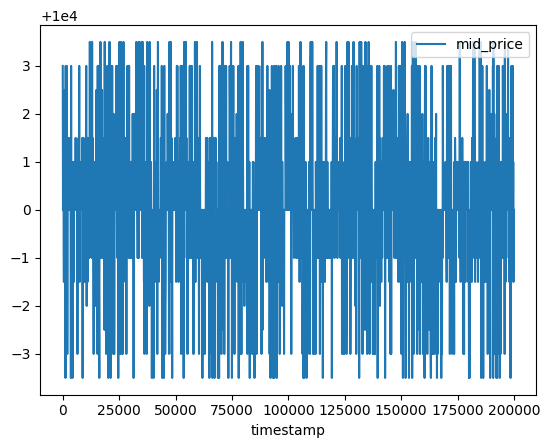

In [39]:
ame.plot(x='timestamp',y='mid_price')

<Axes: ylabel='Frequency'>

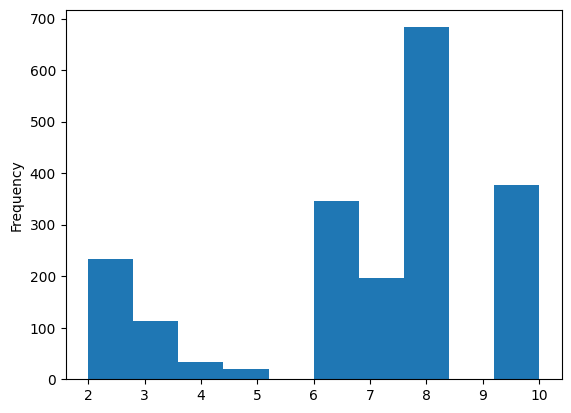

In [40]:
ame['bbo_spread'].plot(kind='hist')

<Axes: ylabel='Frequency'>

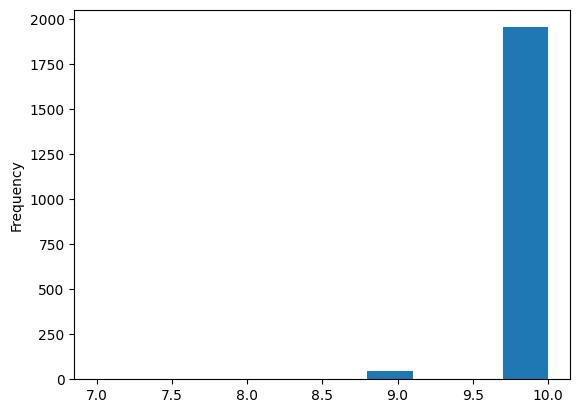

In [41]:
ame['wbo_spread'].plot(kind='hist')

In [14]:
ame

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,bbo_spread,wbo_spread
0,-2,0,AMETHYSTS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0,2,10.0
2,-2,100,AMETHYSTS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0,8,10.0
5,-2,200,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0,10,10.0
6,-2,300,AMETHYSTS,9996,2,9995.0,29.0,NaN,NaN,10004,2,10005.0,29.0,NaN,NaN,10000.0,0.0,8,10.0
8,-2,400,AMETHYSTS,9996,2,9995.0,25.0,NaN,NaN,10004,2,10005.0,25.0,NaN,NaN,10000.0,0.0,8,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,-2,199500,AMETHYSTS,10002,1,9996.0,1.0,9995.0,22.0,10004,1,10005.0,22.0,NaN,NaN,10003.0,0.0,2,10.0
3992,-2,199600,AMETHYSTS,9996,1,9995.0,21.0,NaN,NaN,10002,7,10004.0,1.0,10005.0,21.0,9999.0,0.0,6,10.0
3995,-2,199700,AMETHYSTS,9998,8,9996.0,2.0,9995.0,25.0,10004,2,10005.0,25.0,NaN,NaN,10001.0,0.0,6,10.0
3997,-2,199800,AMETHYSTS,9995,21,NaN,NaN,NaN,NaN,10002,8,10005.0,21.0,NaN,NaN,9998.5,0.0,7,10.0


In [15]:
star = sample_data[sample_data['product']!='AMETHYSTS'].copy()

<Axes: xlabel='timestamp'>

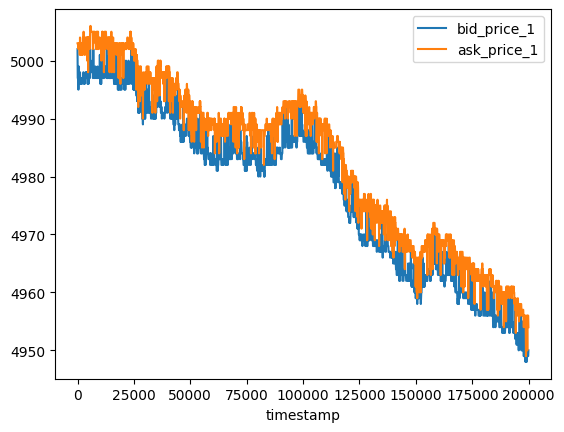

In [16]:
star.plot(x='timestamp',y=['bid_price_1','ask_price_1'])

<Axes: ylabel='Frequency'>

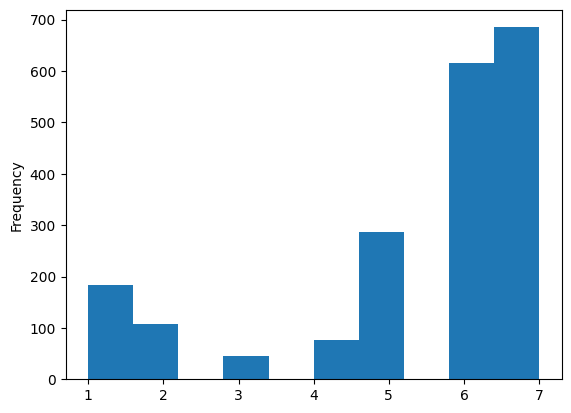

In [17]:
star['bbo_spread'].plot(kind='hist',bins=10)

<Axes: ylabel='Frequency'>

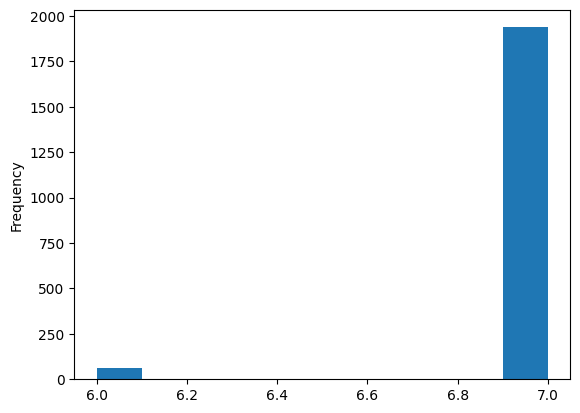

In [18]:
star['wbo_spread'].plot(kind='hist',bins=10)

In [19]:
ame

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,bbo_spread,wbo_spread
0,-2,0,AMETHYSTS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0,2,10.0
2,-2,100,AMETHYSTS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0,8,10.0
5,-2,200,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0,10,10.0
6,-2,300,AMETHYSTS,9996,2,9995.0,29.0,NaN,NaN,10004,2,10005.0,29.0,NaN,NaN,10000.0,0.0,8,10.0
8,-2,400,AMETHYSTS,9996,2,9995.0,25.0,NaN,NaN,10004,2,10005.0,25.0,NaN,NaN,10000.0,0.0,8,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,-2,199500,AMETHYSTS,10002,1,9996.0,1.0,9995.0,22.0,10004,1,10005.0,22.0,NaN,NaN,10003.0,0.0,2,10.0
3992,-2,199600,AMETHYSTS,9996,1,9995.0,21.0,NaN,NaN,10002,7,10004.0,1.0,10005.0,21.0,9999.0,0.0,6,10.0
3995,-2,199700,AMETHYSTS,9998,8,9996.0,2.0,9995.0,25.0,10004,2,10005.0,25.0,NaN,NaN,10001.0,0.0,6,10.0
3997,-2,199800,AMETHYSTS,9995,21,NaN,NaN,NaN,NaN,10002,8,10005.0,21.0,NaN,NaN,9998.5,0.0,7,10.0
